In [1]:
%load_ext lab_black

In [1]:
import os

os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib_functions as mympf

mympf.setMatplotlibParam()
plt.viridis()
import joblib
import pickle
from include.generators import Generator
from saver import Saver
from include.callbacks import get_modelcheckpoint, ExtraValidation
from keras.utils.vis_utils import plot_model
import model_eval
from Data import Data_train, Data_eval
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger
import models.reg as rm
from include.loss import rmae
from include.loss import rmae

from keras import backend as K

2023-02-23 17:38:57.742191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 17:38:57.846018: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


<Figure size 1920x1440 with 0 Axes>

In [2]:
path_train_nc = "/libre/dumontj/coco2/dl-input/2km_forLip/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forLip/valid_dataset.nc"
path_extra_valid_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/valid_dataset.nc"

In [100]:
data = Data_train(path_train_nc, path_valid_nc, path_extra_valid_nc)
data.prepare_input("xco2")
data.prepare_output_inversion()

data.x.train.shape (12576, 64, 64, 1)


In [101]:
reg_builder = rm.Reg_model_builder(
    "essential",
    data.x.fields_input_shape,
    data.y.classes,
    data.x.n_layer,
    data.x.xco2_noisy_chans,
)
model = reg_builder.get_model()
model.compile("adam", "MeanAbsoluteError")

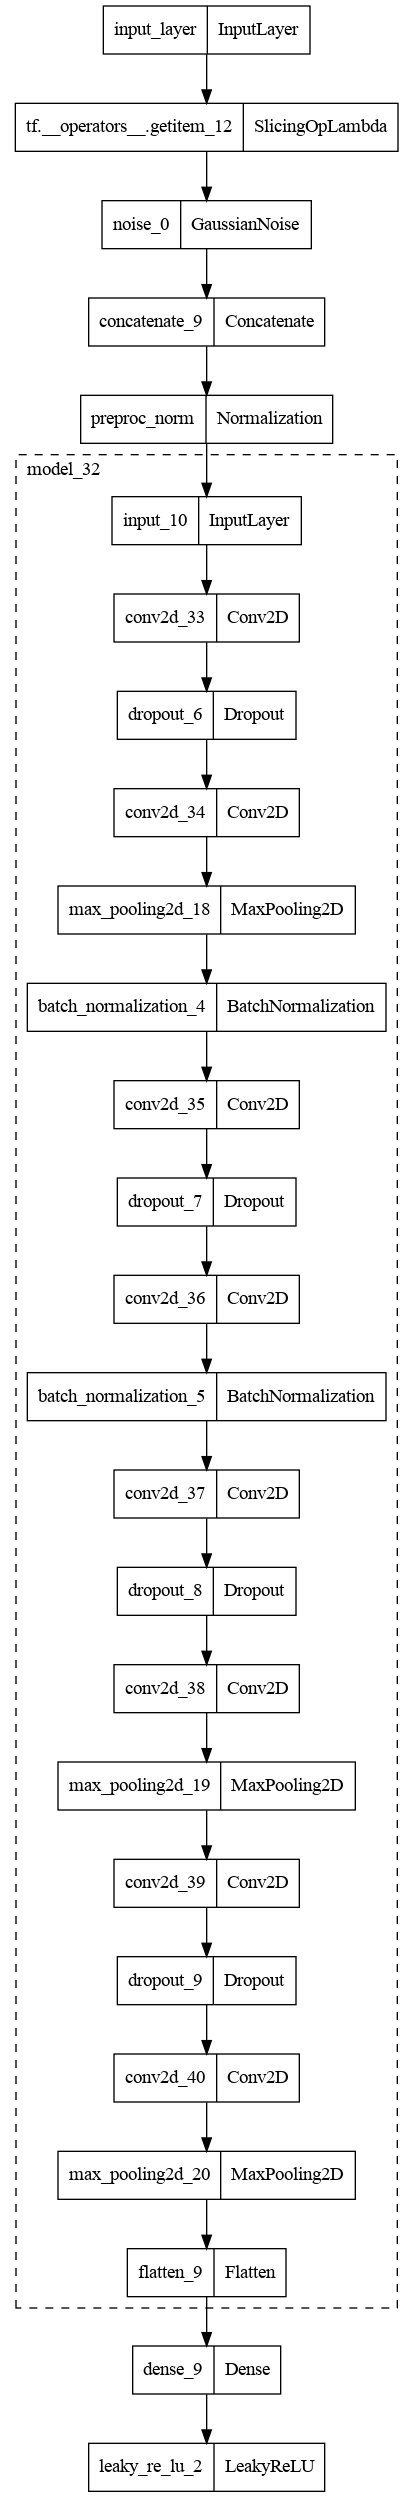

In [89]:
plot_model(model, expand_nested=True)

In [90]:
model.summary(expand_nested=True)

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 1)]       0         
                                                                 
 tf.__operators__.getitem_12  (None, 64, 64, 1)        0         
  (SlicingOpLambda)                                              
                                                                 
 noise_0 (GaussianNoise)     (None, 64, 64, 1)         0         
                                                                 
 concatenate_9 (Concatenate)  (None, 64, 64, 1)        0         
                                                                 
 preproc_norm (Normalization  (None, 64, 64, 1)        3         
 )                                                               
                                                                 
 model_32 (Functional)       (None, 576)               185

In [91]:
def make_get_layer_output(
    model: tf.keras.Model, layer_name: str
) -> tf.keras.backend.function:
    get_layer_output = K.function(
        [model.layers[0].input], [model.get_layer(layer_name).get_output_at(1)]
    )
    return get_layer_output

In [92]:
model.get_layer("preproc_norm").get_output_at(2)

<KerasTensor: shape=(None, 64, 64, 1) dtype=float32 (created by layer 'preproc_norm')>

In [93]:
get_layer_output = make_get_layer_output(model, "preproc_norm")

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name='input_layer'), name='input_layer', description="created by layer 'input_layer'") at layer "tf.__operators__.getitem_10". The following previous layers were accessed without issue: []

In [ ]:
get_layer_output([data.x.valid])[0][:, :, :, 0].mean()

In [94]:
tf.keras.backend.set_learning_phase(1)
get_layer_output = make_get_layer_output(model, "noise_0")
idx_train = np.random.choice(range(data.x.train.shape[0]))
axs = mympf.set_figure_axs(1, 2)
im0 = axs[0].imshow(get_layer_output([data.x.train])[0][idx_train, :, :, 0])
plt.colorbar(im0, orientation="vertical")
im1 = axs[1].imshow(np.squeeze(data.x.train[idx_train, :, :, 0]))
plt.colorbar(im1, orientation="vertical")
tf.keras.backend.set_learning_phase(0)

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


ValueError: Asked to get output at node 1, but the layer has only 1 inbound nodes.